# Importing Necessary Libraries

In [179]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import sklearn.metrics
import torch.nn as nn
import torch.nn.functional as F
import sys
import numpy as np
import os
import seaborn as sns
import time


In [2]:
batchSize = 100

In [3]:
def loadDataSet(): # Loading DataSet - Seems to work
  """
  60k Train Data in batches of "batchSize"
  10k Test Data
  """
  Transform = transforms.ToTensor()
  train = torchvision.datasets.MNIST('./data' , train=True, transform= Transform, download=True)
  testData = torchvision.datasets.MNIST('./data' , train=False, transform= Transform , download = True)
  trainData, validData = torch.utils.data.random_split(train, [50000, 10000])
  trainDataLoader = DataLoader(trainData , batch_size = batchSize , shuffle = True , num_workers = 2)
  validDataLoader = DataLoader(validData, batch_size = batchSize , shuffle = True , num_workers = 2)
  return trainDataLoader , testData , trainData , validDataLoader, validData


In [4]:
train_loader , testData, trainData, test_loader, validData = loadDataSet() # Loading the Datasets

In [5]:
def creatingOutputVector(trainLabels):
  """
  trainLabels - Labels of Input Train Data of a Partiular Batch. (Size: batchSize X 1)
  yReal - True Output. Size: (batchSize X 10)
  """
  batchSize = len(trainLabels)
  yReal = np.zeros([batchSize , 10]) # BatchSize X 10 Matrix
  for j in range(batchSize):
    yReal[j][trainLabels[j]] = 1
  return yReal

# MNIST classification using CNN


Defining the Network

In [6]:
class network(nn.Module):
  def __init__(self):
    super(network, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 1 , out_channels= 32 , 
                           kernel_size = 3, stride = 1 , padding = 1)
    self.conv2 = nn.Conv2d(in_channels = 32 , out_channels= 32 , 
                           kernel_size = 3, stride = 1 , padding = 1)
    self.fc1 = nn.Linear(in_features = 7*7*32 , out_features  = 500)
    self.fc2 = nn.Linear(in_features = 500 , out_features  = 10)
    self.activ = nn.ReLU()
  def pooling(self , X , kernel_size  = 2):
    out = F.max_pool2d(X , kernel_size)
    return out
  
  def forward(self, X):
    out = self.activ(self.conv1(X))
    out = self.pooling(out)
    out = self.activ(self.conv2(out))
    out = self.pooling(out)
    out = torch.flatten(out , start_dim = 1)
    out = self.activ(self.fc1(out))
    out = self.activ(self.fc2(out))
    return out, 0 , 0

In [7]:
def pbar(p=0, msg="", bar_len=20):
    sys.stdout.write("\033[K")
    sys.stdout.write("\x1b[2K" + "\r")
    block = int(round(bar_len * p))
    text = "Progress: [{}] {}% {}".format(
        "\x1b[32m" + "=" * (block - 1) + ">" + "\033[0m" + "-" * (bar_len - block),
        round(p * 100, 2),
        msg,
    )
    print(text, end="\r")
    if p == 1:
        print()


class AvgMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.metrics = {}

    def add(self, batch_metrics):
        if self.metrics == {}:
            for key, value in batch_metrics.items():
                self.metrics[key] = [value]
        else:
            for key, value in batch_metrics.items():
                self.metrics[key].append(value)

    def get(self):
        return {key: np.mean(value) for key, value in self.metrics.items()}

    def msg(self):
        avg_metrics = {key: np.mean(value) for key, value in self.metrics.items()}
        return "".join(["[{}] {:.5f} ".format(key, value) for key, value in avg_metrics.items()])

In [8]:
def train(model, optim, lr_sched=None, epochs=200, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), criterion=None, metric_meter=None, out_dir="out/"):
  model.to(device)
  best_acc = 0
  trainError = []
  validError = []
  predAcc = []
  for epoch in range(epochs):
    model.train()
    metric_meter.reset()
    for indx, (img, target) in enumerate(train_loader):
      # TODO: send to device (cpu or gpu)
      img = img.to(device)
      target = target.to(device)

      # TODO: missing forward pass
      out, out1 , out2 = model(img)
      loss = criterion(out, target)
      # TODO: missing backward, parameter update
      optim.zero_grad()
      loss.backward()
      optim.step()
      cost = loss.item()
      if indx % 5 == 0:
        trainError.append(cost)

      metric_meter.add({"train loss": cost})
      pbar(indx / len(train_loader), msg=metric_meter.msg())
    print('Please Work')
    pbar(1, msg=metric_meter.msg())

    model.eval()
    metric_meter.reset()
    for indx, (img, target) in enumerate(test_loader):
      # TODO: send to device (cpu or gpu)
      img = img.to(device)
      target = target.to(device)

      # TODO: missing forward pass
      out, out1 , out2 = model(img)
      loss = criterion(out, target)
      cost = loss.item()
      if indx % 5 == 0:
        validError.append(cost)
      # TODO: compute accuracy
      yPred = F.softmax(out , dim =1)
      predictedNumber = torch.argmax(yPred , dim = 1)
      noOfRightPrediction = torch.sum(predictedNumber == target)
      totalPrediction = yPred.shape[0]
      acc = noOfRightPrediction/totalPrediction
      acc = acc.cpu().detach().numpy()
      if indx % 5 == 0:
        predAcc.append(acc)

      metric_meter.add({"test loss": loss.item(), "test acc": acc})
      pbar(indx / len(test_loader), msg=metric_meter.msg())
    pbar(1, msg=metric_meter.msg())
    
    test_metrics = metric_meter.get()
    if test_metrics["test acc"] > best_acc:
      print(
          "\x1b[33m"
          + f"test acc improved from {round(best_acc, 5)} to {round(test_metrics['test acc'], 5)}"
          + "\033[0m"
      )
      best_acc = test_metrics['test acc']
      torch.save(model.state_dict(), os.path.join(out_dir, "best.ckpt"))
    lr_sched.step()
  plt.plot(trainError)
  plt.xlabel('Epochs')
  plt.ylabel('Training Error')
  plt.show()
  plt.plot(validError)
  plt.xlabel('Epochs')
  plt.ylabel('Validation Error')
  plt.show()
  plt.plot(predAcc)
  plt.xlabel('Epochs')
  plt.ylabel('Prediction Accuracy')
  plt.show()

In [9]:
def run_experiment(model_name , epochs=200):
  if model_name == 'Network':
    model = network()
  elif model_name == 'Network with BN': 
    model = networkWithBatch()
  elif model_name == 'Vis':
    model = networkVis()
  optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)
  lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)
  criterion = nn.CrossEntropyLoss()
  metric_meter = AvgMeter()
  out_dir = f"{model_name}"
  os.makedirs(out_dir, exist_ok=True)
  train(model, optim, lr_sched, epochs=epochs, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir)
  return model

In [10]:
def predictPy(testData , model):

  temp = testData.data 
  X = (1./255)*torch.reshape(temp , (10000 , 1 , 28 , 28))
  target = testData.targets
  yReal = torch.tensor(creatingOutputVector(testData.targets))
  out, o1, o2 = model(X)
  yPred = F.softmax(out , dim =1)


  predictedNumber = torch.argmax(yPred , dim = 1)
  realNumber = torch.argmax(yReal ,dim = 1)



  noOfRightPrediction = torch.sum(predictedNumber == realNumber)
  totalPrediction = yPred.shape[0]
  acc = noOfRightPrediction/totalPrediction
  



  return acc


## Report



1.   Dimensions of Input and Output at each Layer
  *   Input - 1 X 28 X 28
  *   conv1
      *   Input - 1 X 28 X 28
      *   Output - 32 X 28 X 28
      *   Parameters - 320
  *   maxPool1
      * Input - 32 X 28 X 28
      * Output - 32 X 14 X 14
  * conv2
      * Input - 32 X 14 X 14
      * Output - 32 X 14 X 14
      * Parameters - 320
  * maxPool2
      * Input - 32 X 14 X 14
      * Output - 32 X 7 X 7
  * FC1
      * Input - 1568 X 1
      * Output - 500 X 1
      * Parameters - 1568 X 500
  * FC2
      * Input - 500 X 1
      * Output - 10 X 1
      * Parameters - 500 X 10
2. Total Number of Parameters - 320 + 320 + 78400 + 5000 + 500 + 10 = 84550 (Including Biases)
3. No. of parameters in FC = 78400 + 5000 + 500 + 10 = 83910
4. No. of parameters in Convolutional Layers = 640
5. Number of Neurons in Convolutional Layers= 784 + 6272 = 7056 (Excluded Pooling Layers)
6. Number of Neurons in FC - 1568 + 500 + 10 = 2078


      









In [184]:
def displayImages(data , model):
  """
  Displaying 'numberOfImages' Random Images
  numberOfImages - Even Number
  """
  ix=1
  fig, ax = plt.subplots(8, 4, figsize=(10,10))
  fig.tight_layout()

  for filter in range(32):
    randInt = torch.randint(0 , len(data)+1 , (1,))
    ax = plt.subplot(8, 4, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    image  = data.data[randInt]
    image = (1./255)*torch.reshape(image , (1 , 1 , 28 , 28))
    out, o1 , o2 = model(image)
    image = 255*torch.reshape(image , (28 , 28))
    yPred = F.softmax(out , dim =1)
    predictedNumber = torch.argmax(yPred , dim = 1)
    ax.title.set_text('Predicted Number {}'.format(int(predictedNumber)))
    plt.imshow(image,cmap='Greys')
    ix+=1




# Training 

Please Work
Progress: [===================>] 100% [train loss] 1.58840 
Progress: [===================>] 100% [test loss] 0.86917 [test acc] 0.74180 
test acc improved from 0 to 0.7418000102043152
Please Work
Progress: [===================>] 100% [train loss] 0.66897 
Progress: [===================>] 100% [test loss] 0.55872 [test acc] 0.87110 
test acc improved from 0.7418000102043152 to 0.8711000084877014
Please Work
Progress: [===================>] 100% [train loss] 0.53193 
Progress: [===================>] 100% [test loss] 0.51909 [test acc] 0.88240 
test acc improved from 0.8711000084877014 to 0.8823999762535095
Please Work
Progress: [===================>] 100% [train loss] 0.51049 
Progress: [===================>] 100% [test loss] 0.50968 [test acc] 0.88590 
test acc improved from 0.8823999762535095 to 0.8859000205993652
Please Work
Progress: [===================>] 100% [train loss] 0.50190 
Progress: [===================>] 100% [test loss] 0.50740 [test acc] 0.88650 
test acc im

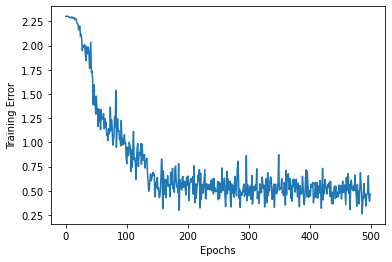

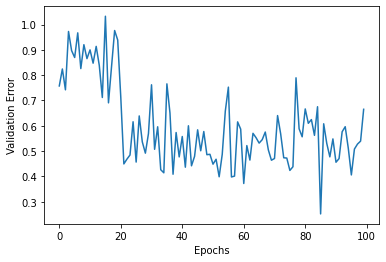

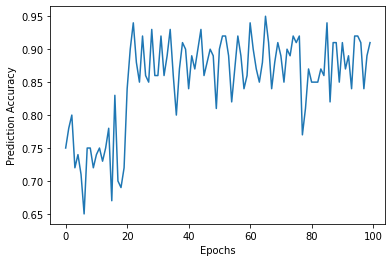

Execution Time --- 274.8086667060852 seconds ---


In [180]:
start_time = time.time()
model = run_experiment('Network' , epochs = 5)
print("Execution Time --- %s seconds ---" % (time.time() - start_time))

# Prediction 

In [182]:
acc = predictPy(testData , model)
print('Test Accuracy', float(acc)*100)

Test Accuracy 88.7399971485138


# Displaying Images

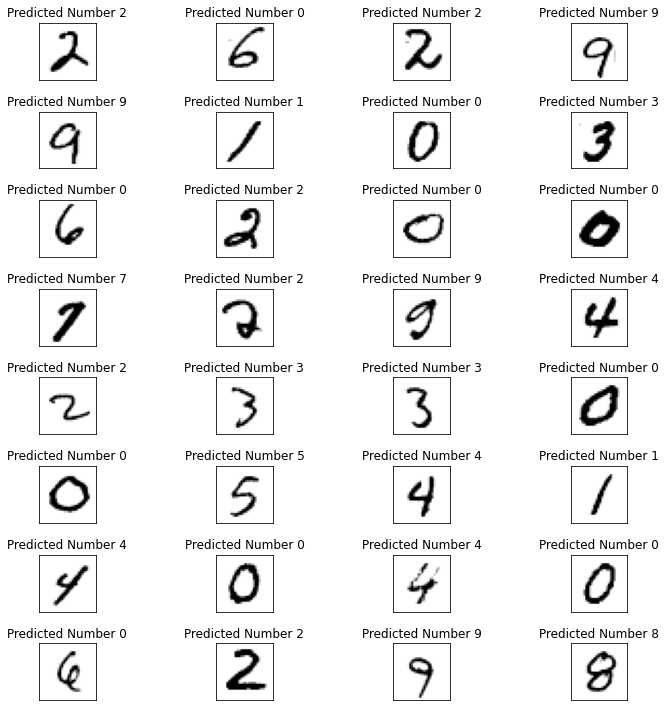

In [185]:
displayImages(testData , model)

# With Batch Normalization

In [187]:
class networkWithBatch(nn.Module):
  def __init__(self):
    super(networkWithBatch, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 1 , out_channels= 32 , 
                           kernel_size = 3, stride = 1 , padding = 1)
    self.batch1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels = 32 , out_channels= 32 , 
                           kernel_size = 3, stride = 1 , padding = 1)
    self.batch2 = nn.BatchNorm2d(32)
    self.fc1 = nn.Linear(in_features = 7*7*32 , out_features  = 500)
    self.fc2 = nn.Linear(in_features = 500 , out_features  = 10)
    self.activ = nn.ReLU()
  def pooling(self , X , kernel_size  = 2):
    out = F.max_pool2d(X , kernel_size)
    return out
  
  def forward(self, X):
    out = self.activ(self.batch1(self.conv1(X)))
    out = self.pooling(out)
    out = self.activ(self.batch2(self.conv2(out)))
    out = self.pooling(out)
    out = torch.flatten(out , start_dim = 1)
    out = self.activ(self.fc1(out))
    out = self.activ(self.fc2(out))
    return out, 0 , 0

Please Work
Progress: [===================>] 100% [train loss] 1.07083 
Progress: [===================>] 100% [test loss] 1.00453 [test acc] 0.58720 
test acc improved from 0 to 0.5871999859809875
Please Work
Progress: [===================>] 100% [train loss] 0.97187 
Progress: [===================>] 100% [test loss] 0.97162 [test acc] 0.59040 
test acc improved from 0.5871999859809875 to 0.590399980545044
Please Work
Progress: [===================>] 100% [train loss] 0.95645 
Progress: [===================>] 100% [test loss] 0.96704 [test acc] 0.59090 
test acc improved from 0.590399980545044 to 0.5909000039100647
Please Work
Progress: [===================>] 100% [train loss] 0.78592 
Progress: [===================>] 100% [test loss] 0.73210 [test acc] 0.69510 
test acc improved from 0.5909000039100647 to 0.6951000094413757
Please Work
Progress: [===================>] 100% [train loss] 0.71473 
Progress: [===================>] 100% [test loss] 0.72814 [test acc] 0.69610 
test acc impr

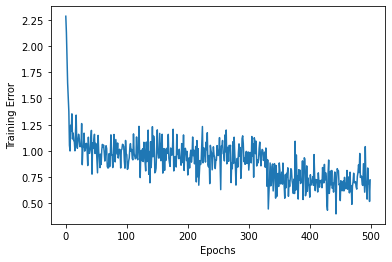

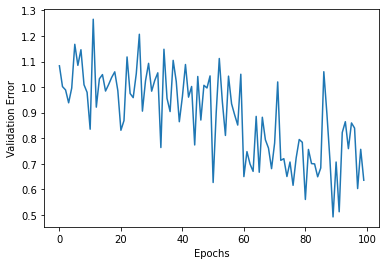

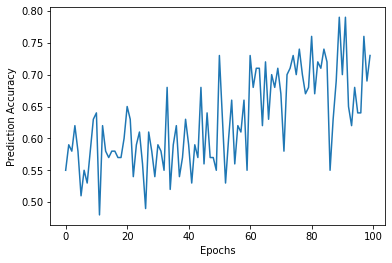

Execution Time --- 350.0379226207733 seconds ---


In [188]:
start_time = time.time()
modelWithBN = run_experiment('Network with BN' , epochs = 5)
print("Execution Time --- %s seconds ---" % (time.time() - start_time))

Question: Use batch-normalization. Does it improve the test accuracy? Does it affect training time?

Batch-normalization, has resulted in increased training time and decreased accuracy. The decreased accuracy probably, is because of the low number of epochs taken and normalization. 

With BN Train Time - 350.0379226207733 secs

Without BN - 274.8086667060852 secs

In [ ]:
acc = predictPy(testData , modelWithBN)
print('Test Accuracy', float(acc)*100)

Test Accuracy 78.68000268936157


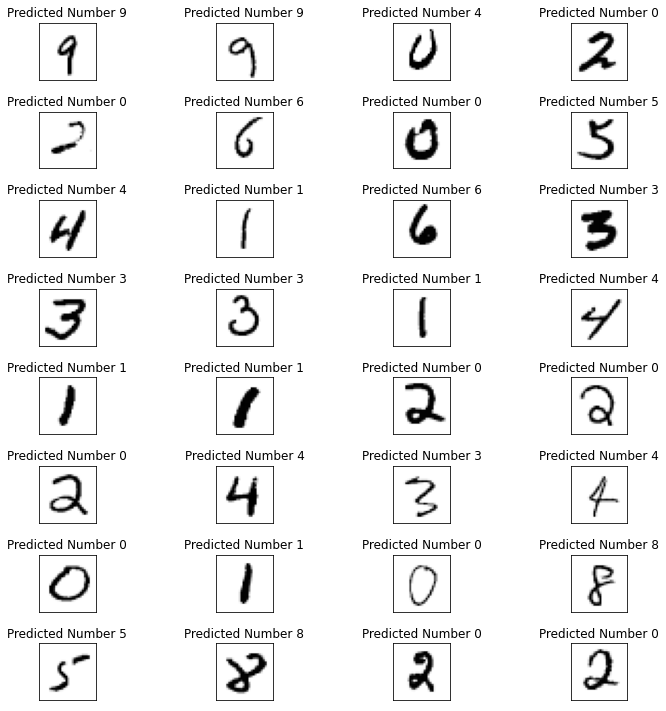

In [ ]:
displayImages(testData , modelWithBN)

# Visualizing the Convolutional Neural Network

In [11]:
class networkVis(nn.Module):
  def __init__(self):
    super(networkVis, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 1 , out_channels= 32 , 
                           kernel_size = 3, stride = 1 , padding = 1)
    self.conv2 = nn.Conv2d(in_channels = 32 , out_channels= 32 , 
                           kernel_size = 3, stride = 1 , padding = 1)
    self.fc1 = nn.Linear(in_features = 7*7*32 , out_features  = 500)
    self.fc2 = nn.Linear(in_features = 500 , out_features  = 10)
    self.activ = nn.ReLU()
  def pooling(self , X , kernel_size  = 2):
    out = F.max_pool2d(X , kernel_size)
    return out
  
  def forward(self, X):
    out = self.activ(self.conv1(X))
    outAct1 = out
    out = self.pooling(out)
    out = self.activ(self.conv2(out))
    outAct2 = out
    out = self.pooling(out)
    out = torch.flatten(out , start_dim = 1)
    out = self.activ(self.fc1(out))
    out = self.activ(self.fc2(out))
    return out, outAct1 , outAct2



    

Please Work
Progress: [===================>] 100% [train loss] 0.68119 
Progress: [===================>] 100% [test loss] 0.14909 [test acc] 0.95550 
test acc improved from 0 to 0.9555000066757202
Please Work
Progress: [===================>] 100% [train loss] 0.11001 
Progress: [===================>] 100% [test loss] 0.09302 [test acc] 0.97020 
test acc improved from 0.9555000066757202 to 0.9702000021934509
Please Work
Progress: [===================>] 100% [train loss] 0.06787 
Progress: [===================>] 100% [test loss] 0.06824 [test acc] 0.97910 
test acc improved from 0.9702000021934509 to 0.9790999889373779
Please Work
Progress: [===================>] 100% [train loss] 0.05116 
Progress: [===================>] 100% [test loss] 0.05689 [test acc] 0.98160 
test acc improved from 0.9790999889373779 to 0.9815999865531921
Please Work
Progress: [===================>] 100% [train loss] 0.04220 
Progress: [===================>] 100% [test loss] 0.05231 [test acc] 0.98380 
test acc im

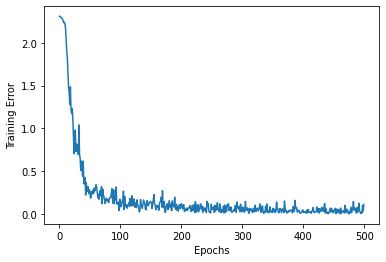

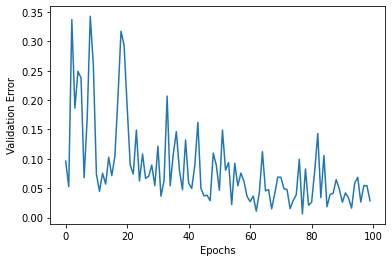

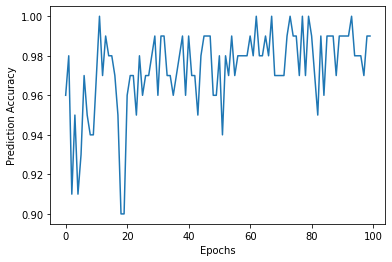

In [12]:
modelWithVis = run_experiment('Vis' , epochs = 5)

In [ ]:
temp = testData.data[0] 
X = (1./255)*torch.reshape(temp , (1 , 1 , 28 , 28))

In [ ]:
out, outAct1 , outAct2 = modelWithVis(X)

In [181]:
acc = predictPy(testData , modelWithVis)
print('Test Accuracy', float(acc)*100)

Test Accuracy 98.5700011253357


# Filters from First Convolution Layers

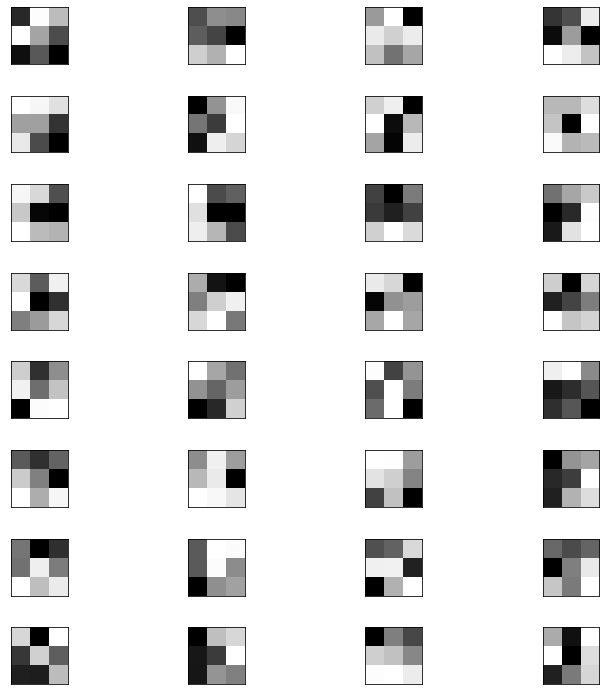

In [ ]:
conv1Weights = modelWithVis.conv1.weight
ix=1
fig, ax = plt.subplots(8, 4, figsize=(10,10))
fig.tight_layout()

for filter in conv1Weights:
    ax = plt.subplot(8, 4, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    filter = filter.detach()
    filter_image=filter.numpy()[0]
    plt.imshow(filter_image,cmap='Greys')
    ix+=1
plt.show()


Question: Plot the the conv1 layer filters. Do you observe interesting patterns?

There does not seem to be any observable pattern, this is probably, due to small filter size. But, these filters kinda seem like edge filters

# Filters from Second Convolutional layer

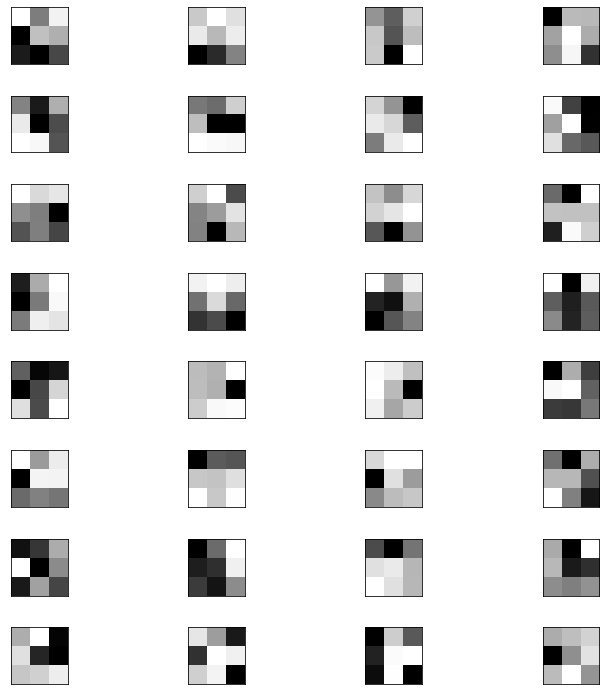

In [ ]:
conv1Weights = modelWithVis.conv2.weight
ix=1
fig, ax = plt.subplots(8, 4, figsize=(10,10))
fig.tight_layout()

for filter in conv1Weights:
    ax = plt.subplot(8, 4, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    filter = filter.detach()
    filter_image=filter.numpy()[0]
    plt.imshow(filter_image,cmap='Greys')
    ix+=1
plt.show()

Question: Plot filters of a higher layer and compare them with conv1 layer filters

Still, there isn't much recognizable pattern. But these filters, does not seem like edge detectors unlike the lower layer


# Visualizing the Activations of Convolutional layers

First Activation

In [ ]:
img , label = testData[6]
img = torch.reshape(img , (1 , 1 , 28 , 28))
out, out1, out2 = modelWithVis(img)
mulFact1 = torch.max(out1) - torch.min(out1)
mulFact2 = torch.max(out2) - torch.min(out2)
out1 = torch.reshape(out1 , (32 , 28 , 28))/mulFact1
out2 = torch.reshape(out2 , (32 , 14 , 14))/mulFact2

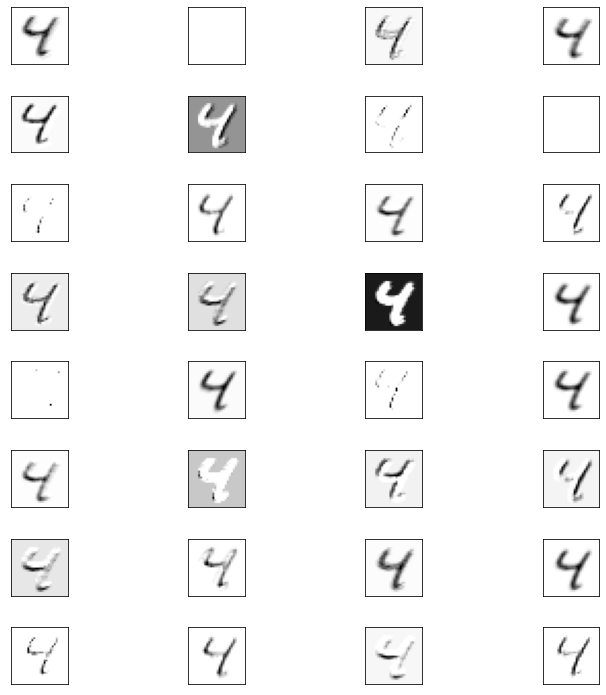

In [ ]:
ix=1
fig, ax = plt.subplots(8, 4, figsize=(10,10))
fig.tight_layout()

for filter in out1:
    ax = plt.subplot(8, 4, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    filter = filter.detach()
    filter_image=filter.numpy()
    plt.imshow(filter_image,cmap='Greys')
    ix+=1
plt.show()

Question: Visualize the activations of the convolutional layers. What do you observe as you go deeper?

The activations of the conv Layers, seem to be the edges and corners of the input images. 

Second Activation

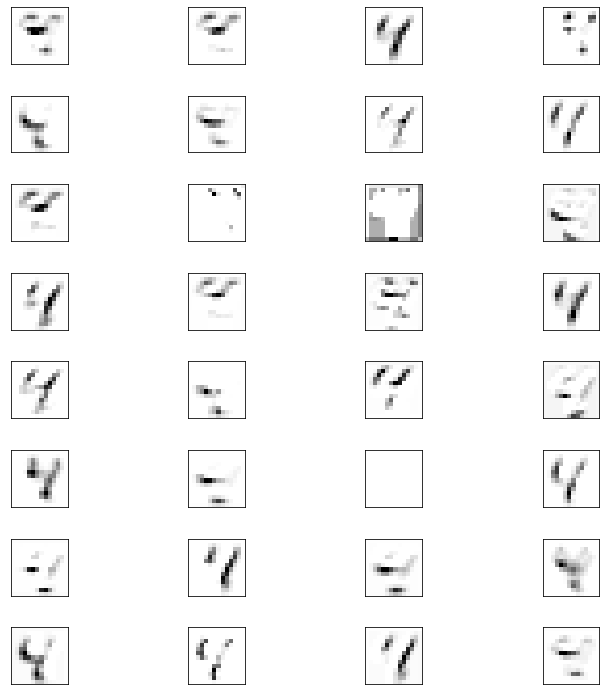

In [ ]:
ix=1
fig, ax = plt.subplots(8, 4, figsize=(10,10))
fig.tight_layout()

for filter in out2:
    ax = plt.subplot(8, 4, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    filter = filter.detach()
    filter_image=filter.numpy()
    plt.imshow(filter_image,cmap='Greys')
    ix+=1
plt.show()

The second activations of the conv Layer, relatively less clear, but they also seem to be the edges and corners of the input images. 

# Occulusion Analysis

In [189]:
def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):

    """custom function to conduct occlusion experiments"""
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
    #print(width , height)
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            #temp = torch.reshape(input_image , (28 , 28))
            #temp = temp.detach()
            #plt.imshow(temp)
            #plt.show()
            if torch.cuda.is_available(): input_image = input_image.cuda()
            
            #run inference on modified image
            output, o1 , o2 = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            #print(prob , 'above pic')
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap

Label 1


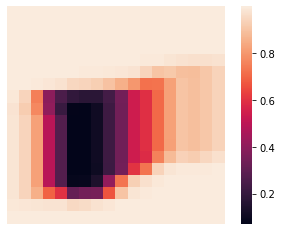

In [193]:
img , label = testData[2]
img = torch.reshape(img , (1 , 1 , 28 , 28))
if torch.cuda.is_available(): img = img.cuda()
outputs, o1,o2 = modelWithVis(img)

#passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#getting the maximum predicted label
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = prob_no_occ[0].item()

#print(prob_no_occ)
heatmap = occlusion(modelWithVis, img, label, occ_size = 10, occ_stride = 1, occ_pixel = 0)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
print('Label' , label)
figure = imgplot.get_figure()    
figure.savefig('svm_conf.png', dpi=1000)
img = torch.reshape(img , (28 , 28))
img = img.detach()
plt.imshow(img , cmap = 'gray')
plt.show()


Label 4


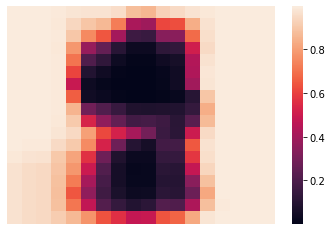

In [195]:
img , label = testData[6]
img = torch.reshape(img , (1 , 1 , 28 , 28))
if torch.cuda.is_available(): img = img.cuda()
outputs, o1,o2 = modelWithVis(img)

#passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#getting the maximum predicted label
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = prob_no_occ[0].item()

#print(prob_no_occ)
heatmap = occlusion(modelWithVis, img, label, occ_size = 10, occ_stride = 1, occ_pixel = 0)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
print('Label' , label)
figure = imgplot.get_figure()    
figure.savefig('svm_conf.png', dpi=1000)


Label 3


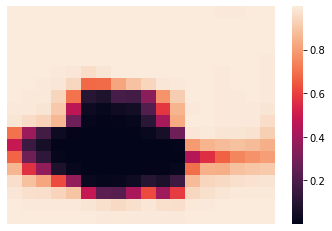

In [196]:
img , label = testData[200]
img = torch.reshape(img , (1 , 1 , 28 , 28))
if torch.cuda.is_available(): img = img.cuda()
outputs, o1,o2 = modelWithVis(img)

#passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#getting the maximum predicted label
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = prob_no_occ[0].item()

#print(prob_no_occ)
heatmap = occlusion(modelWithVis, img, label, occ_size = 10, occ_stride = 1, occ_pixel = 0)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
print('Label' , label)
figure = imgplot.get_figure()    
figure.savefig('svm_conf.png', dpi=1000)


Label 9


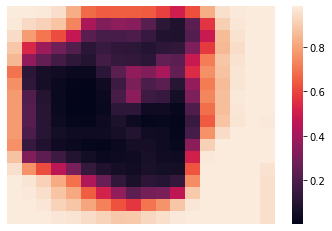

In [197]:
img , label = testData[7]
img = torch.reshape(img , (1 , 1 , 28 , 28))
if torch.cuda.is_available(): img = img.cuda()
outputs, o1,o2 = modelWithVis(img)

#passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#getting the maximum predicted label
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = prob_no_occ[0].item()

#print(prob_no_occ)
heatmap = occlusion(modelWithVis, img, label, occ_size = 10, occ_stride = 1, occ_pixel = 0)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
print('Label' , label)
figure = imgplot.get_figure()    
figure.savefig('svm_conf.png', dpi=1000)


Label 4


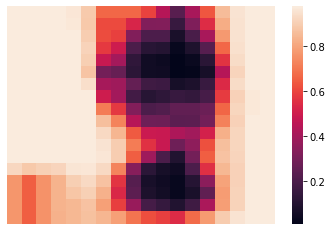

In [198]:
img , label = testData[698]
img = torch.reshape(img , (1 , 1 , 28 , 28))
if torch.cuda.is_available(): img = img.cuda()
outputs, o1,o2 = modelWithVis(img)

#passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#getting the maximum predicted label
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = prob_no_occ[0].item()

#print(prob_no_occ)
heatmap = occlusion(modelWithVis, img, label, occ_size = 10, occ_stride = 1, occ_pixel = 0)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
print('Label' , label)
figure = imgplot.get_figure()    
figure.savefig('svm_conf.png', dpi=1000)


Label 9


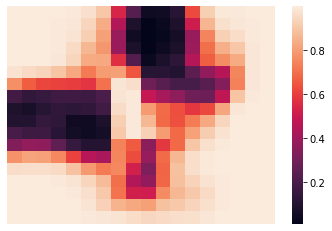

In [199]:
img , label = testData[501]
img = torch.reshape(img , (1 , 1 , 28 , 28))
if torch.cuda.is_available(): img = img.cuda()
outputs, o1,o2 = modelWithVis(img)

#passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#getting the maximum predicted label
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = prob_no_occ[0].item()

#print(prob_no_occ)
heatmap = occlusion(modelWithVis, img, label, occ_size = 10, occ_stride = 1, occ_pixel = 0)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
print('Label' , label)
figure = imgplot.get_figure()    
figure.savefig('svm_conf.png', dpi=1000)


Label 3


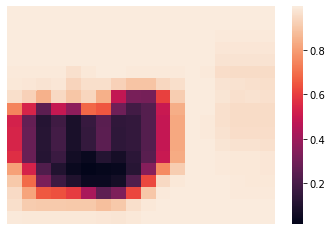

In [205]:
img , label = testData[231]
img = torch.reshape(img , (1 , 1 , 28 , 28))
if torch.cuda.is_available(): img = img.cuda()
outputs, o1,o2 = modelWithVis(img)

#passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#getting the maximum predicted label
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = prob_no_occ[0].item()

#print(prob_no_occ)
heatmap = occlusion(modelWithVis, img, label, occ_size = 10, occ_stride = 1, occ_pixel = 0)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
print('Label' , label)
figure = imgplot.get_figure()    
figure.savefig('svm_conf.png', dpi=1000)


Label 5


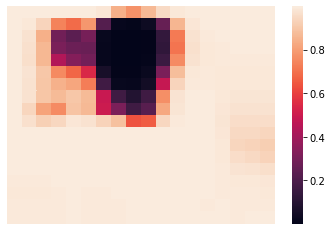

In [206]:
img , label = testData[785]
img = torch.reshape(img , (1 , 1 , 28 , 28))
if torch.cuda.is_available(): img = img.cuda()
outputs, o1,o2 = modelWithVis(img)

#passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#getting the maximum predicted label
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = prob_no_occ[0].item()

#print(prob_no_occ)
heatmap = occlusion(modelWithVis, img, label, occ_size = 10, occ_stride = 1, occ_pixel = 0)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
print('Label' , label)
figure = imgplot.get_figure()    
figure.savefig('svm_conf.png', dpi=1000)


Label 9


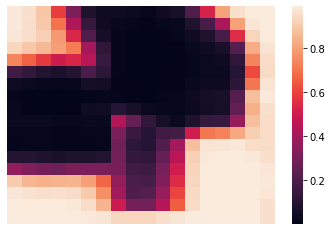

In [207]:
img , label = testData[999]
img = torch.reshape(img , (1 , 1 , 28 , 28))
if torch.cuda.is_available(): img = img.cuda()
outputs, o1,o2 = modelWithVis(img)

#passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#getting the maximum predicted label
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = prob_no_occ[0].item()

#print(prob_no_occ)
heatmap = occlusion(modelWithVis, img, label, occ_size = 10, occ_stride = 1, occ_pixel = 0)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
print('Label' , label)
figure = imgplot.get_figure()    
figure.savefig('svm_conf.png', dpi=1000)


Label 1


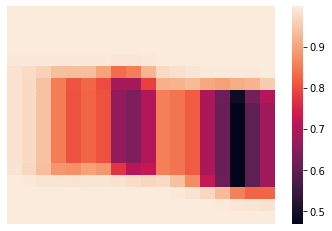

In [208]:
img , label = testData[31]
img = torch.reshape(img , (1 , 1 , 28 , 28))
if torch.cuda.is_available(): img = img.cuda()
outputs, o1,o2 = modelWithVis(img)

#passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#getting the maximum predicted label
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = prob_no_occ[0].item()

#print(prob_no_occ)
heatmap = occlusion(modelWithVis, img, label, occ_size = 10, occ_stride = 1, occ_pixel = 0)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
print('Label' , label)
figure = imgplot.get_figure()    
figure.savefig('svm_conf.png', dpi=1000)


Question: Report if the learning meaningful or not

As we can see from the heat maps, when the occulusion cover a part of the digit, the probability gets lowered. Therefore we can say that, the learning is meaningful

# Adversarial Examples







Non Targeted Attack

In [237]:
def adv_gen_1(model, target_class, mean=128, sigma = 0.1, epochs=30000, plot_cost=False , device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
  X = torch.normal(mean,sigma, size = (1,1,28,28))
  X = X.to(device)
  X.requires_grad = True
  optim = torch.optim.SGD([X],lr=1e-2 , momentum = 0.9 , weight_decay = 0.4)
  cost_matrix =[]

  for i in range(epochs):
    out , o1 , o2 = model(X)
    loss = -out[0][target_class]
    optim.zero_grad()
    loss.backward()
    optim.step()
    cost_matrix.append(-loss.to(torch.device('cpu')).clone().detach())
    

  if plot_cost:
    plt.plot(cost_matrix)
    plt.show()
  out, out1, out2 = model(X)
  _, predicted = out.max(1)
  print('Confidence = ',float(max(torch.nn.functional.softmax(out, dim=1)[0])))
  plt.imshow(X[0][0].to(torch.device('cpu')).detach(),cmap='gray')
  plt.title("Predicted Label {}, Target Label {}".format(predicted.item(), target_class))

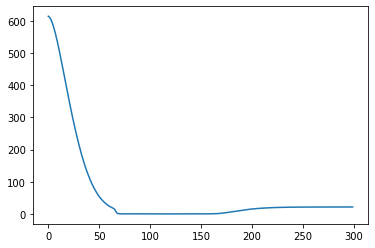

Confidence =  0.9999990463256836


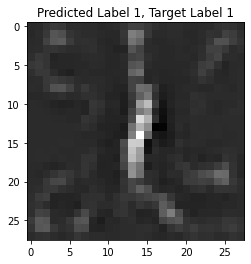

In [238]:
adv_gen_1(modelWithVis, 1, mean=128, sigma = 1, epochs=300, plot_cost=True)

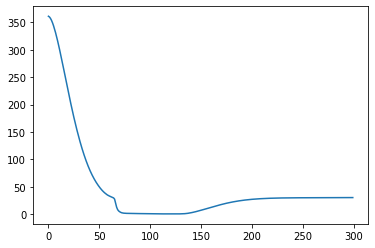

Confidence =  1.0


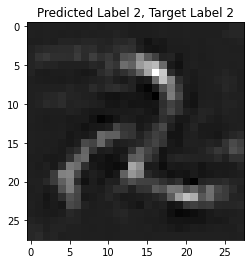

In [239]:
adv_gen_1(modelWithVis, 2, mean=128, sigma = 1, epochs=300, plot_cost=True)

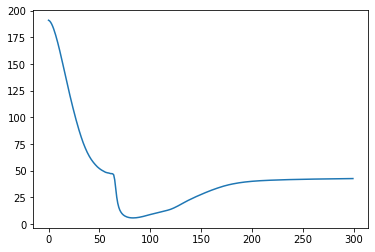

Confidence =  100.0


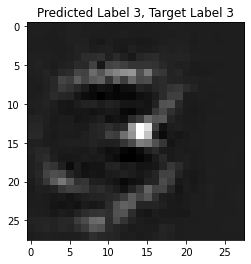

In [236]:
adv_gen_1(modelWithVis, 3, mean=128, sigma = 1, epochs=300, plot_cost=True)

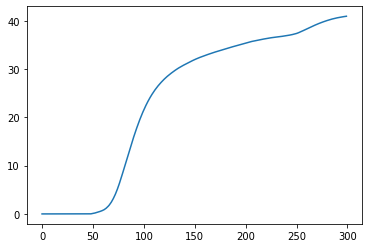

Confidence =  1.0


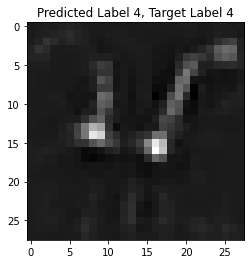

In [240]:
adv_gen_1(modelWithVis, 4, mean=0.5, sigma = 0.1, epochs=300, plot_cost=True)

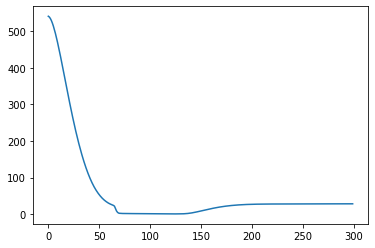

Confidence =  1.0


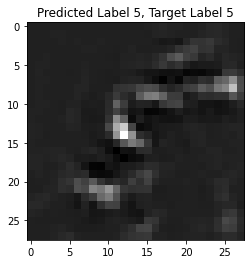

In [241]:
adv_gen_1(modelWithVis, 5, mean=128, sigma = 1, epochs=300, plot_cost=True)

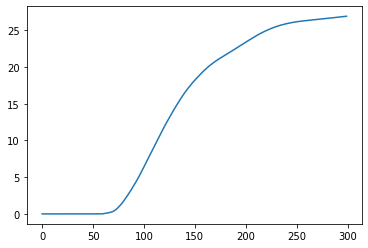

Confidence =  1.0


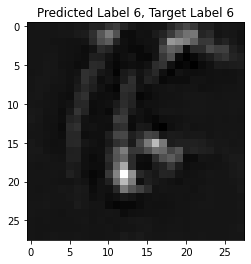

In [242]:
adv_gen_1(modelWithVis, 6, mean=0.5, sigma = 1, epochs=300, plot_cost=True)

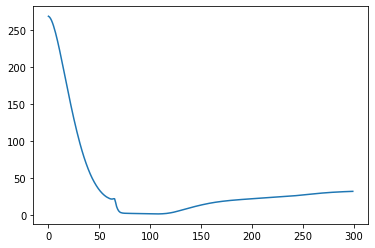

Confidence =  1.0


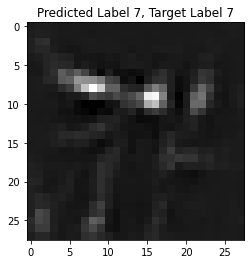

In [243]:
adv_gen_1(modelWithVis, 7, mean=128, sigma = 1, epochs=300, plot_cost=True)

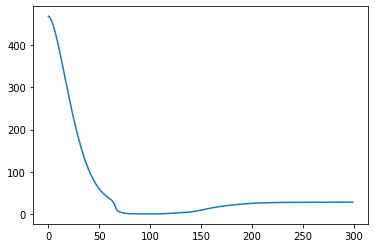

Confidence =  1.0


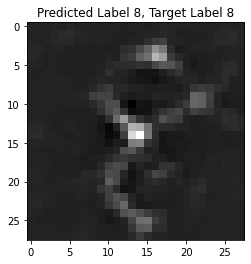

In [244]:
adv_gen_1(modelWithVis, 8, mean=128, sigma = 1, epochs=300, plot_cost=True)

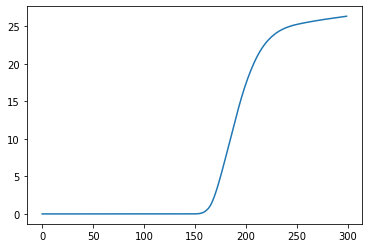

Confidence =  0.9973158240318298


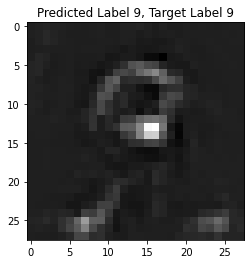

In [245]:
adv_gen_1(modelWithVis, 9, mean=128, sigma = 1, epochs=300, plot_cost=True)

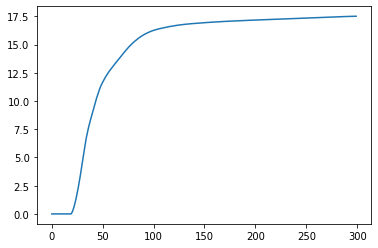

Confidence =  0.9999476671218872


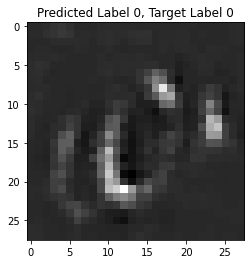

In [248]:
adv_gen_1(modelWithVis, 0, mean=2, sigma = 0.1, epochs=300, plot_cost=True)

**Question: Is the network always predicting targetClass with high confidence for the generated images?**

Yes, the network seems to predict the targetClass with high confidence

**Do the generated images look like a number? If not, can you think of some reason?**

In most cases it does look like the target case, but in few cases, like '0' it is not quite clear. This is probably, because the network is trying to fine tune the noise image to get the target noise. In other words, it is probably, highlighting those pixels of the noisy image, that tends to have a heigh weightage, while predicting the true class. 

**Plot the cost function. Is it increasing or decreasing?**

In few cases, the cost function seems to increase, and in other it does not. This is probably because of overshooting (maybe high learning rate)

Targeted Attack

In [114]:
def adv_gen_2(model, beta, target_class, image, trueLabel, mean=0.5, sigma = 0.1, epochs=30000, plot_cost=False , device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
  X = torch.normal(mean,sigma, size = (1,1,28,28))
  X.requires_grad = True
  comp_img = image[trueLabel]
  comp_img = torch.reshape(comp_img , (1 , 1 , 28 , 28))
  optim = torch.optim.SGD([X],lr=1e-2)
  cost_matrix =[]

  for i in range(epochs):
    out , o1 , o2 = model(X)
    loss = -out[0][target_class]+beta*F.mse_loss(X,comp_img.to(device))
    optim.zero_grad()
    loss.backward()
    optim.step()
    cost_matrix.append(loss.to(torch.device('cpu')).clone().detach())

  if plot_cost:
    plt.plot(cost_matrix)
    plt.show()
  out, out1, out2 = model(X)
  _, predicted = out.max(1)
  plt.imshow(X[0][0].to(torch.device('cpu')).detach(),cmap='gray')
  plt.title("Predicted Label {}, Target Class {}, Target Image {}".format(predicted.item(), target_class, trueLabel))


In [110]:
trueClass = []
image = dict()
for data in testData:
  img , label = data
  if label not in trueClass:
    trueClass.append(label)
    image[label] = img
  if len(trueClass) == 10:
    break


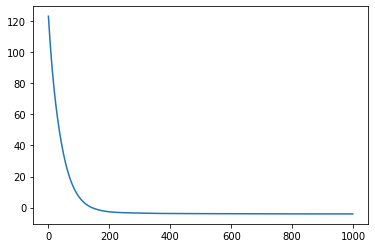

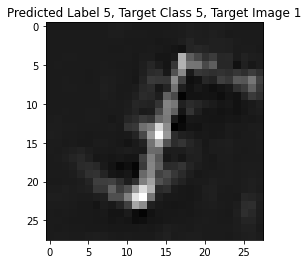

In [121]:
adv_gen_2(modelWithVis, 500,  5 , image, 1 , mean=0.5, sigma = 0.1, epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

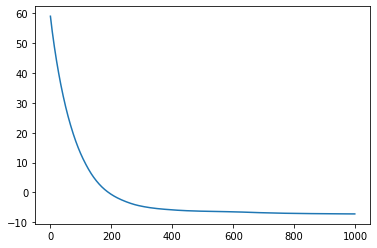

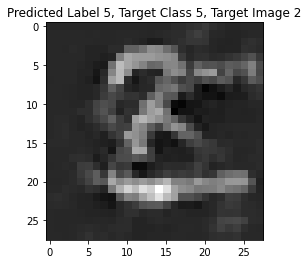

In [124]:
adv_gen_2(modelWithVis, 250,  5 , image, 2 , mean=0.5, sigma = 0.1, epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

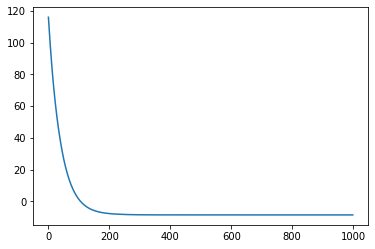

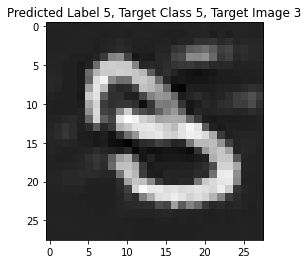

In [125]:
adv_gen_2(modelWithVis, 500,  5 , image, 3 , mean=0.5, sigma = 0.1, epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

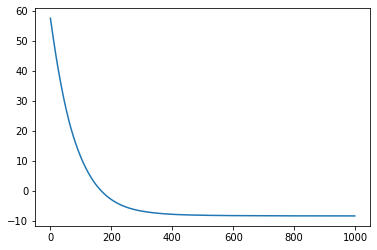

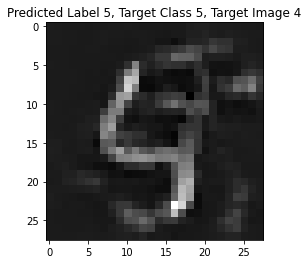

In [127]:
adv_gen_2(modelWithVis, 250,  5 , image, 4 , mean=0.5, sigma = 0.1, epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

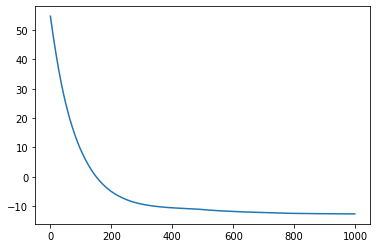

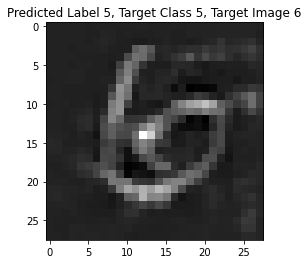

In [129]:
adv_gen_2(modelWithVis, 250,  5 , image, 6 , mean=0.5, sigma = 0.1, epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

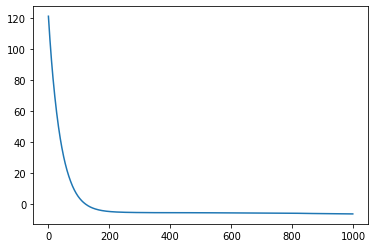

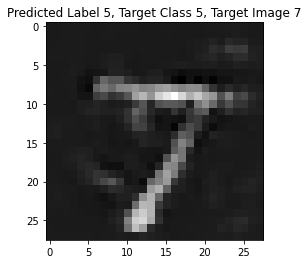

In [130]:
adv_gen_2(modelWithVis, 500,  5 , image, 7 , mean=0.5, sigma = 0.1, epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

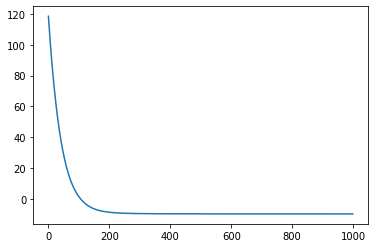

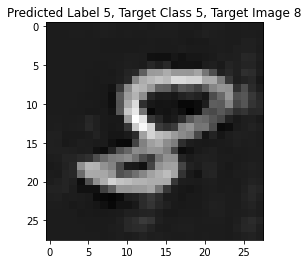

In [131]:
adv_gen_2(modelWithVis, 500,  5 , image, 8 , mean=0.5, sigma = 0.1, epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

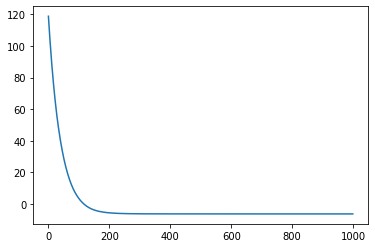

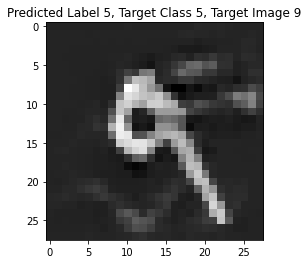

In [132]:
adv_gen_2(modelWithVis, 500,  5 , image, 9 , mean=0.5, sigma = 0.1, epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

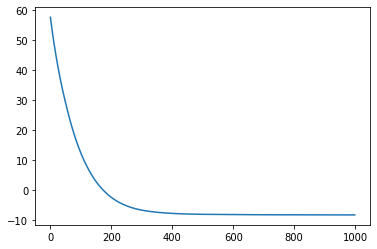

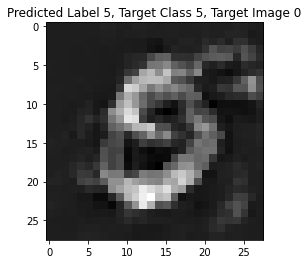

In [134]:
adv_gen_2(modelWithVis, 250,  5 , image, 0 , mean=0.5, sigma = 0.1, epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

**Do the generated images now look like a number?**

In almost all cases, the generated images, look like a number

Adding Noise

In [250]:
def adv_gen_3(model, target_class, real_class, image ,mean = 128 , sigma = 0.1, epochs=30000, plot_cost=False , device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
  X = torch.normal(mean,sigma, size = (1,1,28,28))
  X = X.to(device)
  X.requires_grad = True
  comp_img = image[real_class]
  comp_img = torch.reshape(comp_img , (1 , 1 , 28 , 28))
  comp_img.to(device)
  cost_matrix =[]
  optim = torch.optim.SGD([X],lr=1e-2)
  cost_matrix =[]

  for i in range(epochs):
    out , o1 , o2 = model(X + comp_img.to(device))
    loss = -out[0][target_class]
    optim.zero_grad()
    loss.backward()
    optim.step()
    cost_matrix.append(loss.to(torch.device('cpu')).clone().detach())

  if plot_cost:
    plt.plot(cost_matrix)
    plt.show()
  ans_img=X+comp_img.to(device)
  plt.imshow(ans_img[0][0].to(torch.device('cpu')).detach(),cmap='gray')
  out, out1, out2 = model(ans_img.to(device))
  _, predicted = out.max(1)
  plt.title("Predicted Label {}, Original Label {}, Target Adversarial Class {}".format(predicted.item(), real_class, target_class))
  plt.show()
  plt.imshow(X[0][0].to(torch.device('cpu')).detach(),cmap='gray')
  plt.title("Corresponding Noise")
  plt.show()
  plt.imshow(comp_img[0][0].to(torch.device('cpu')).detach(),cmap='gray')
  plt.title("Orginal Image")
  plt.show()


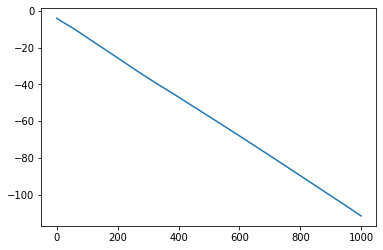

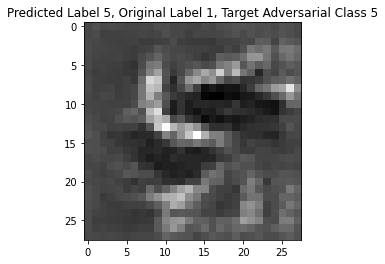

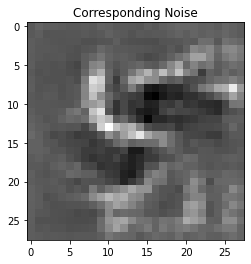

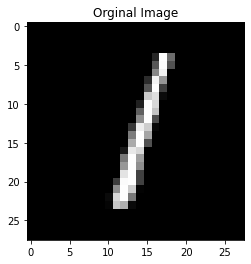

In [251]:
adv_gen_3(modelWithVis, 5, 1, image , mean = 2 , epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

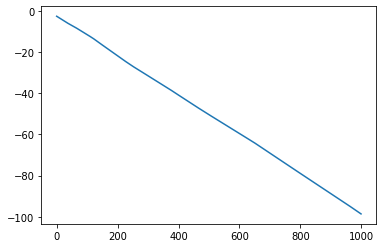

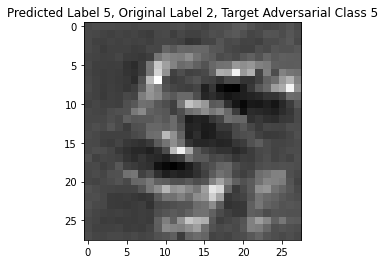

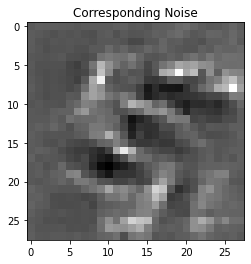

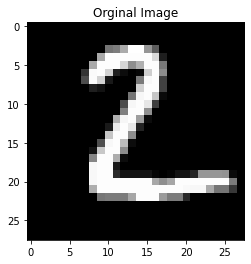

In [158]:
adv_gen_3(modelWithVis, 5, 2, image , mean = 1 , epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

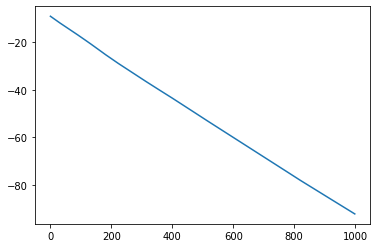

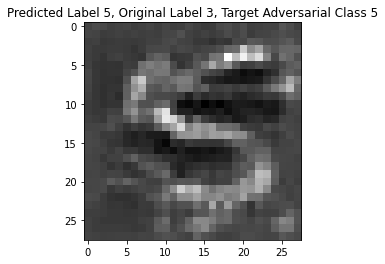

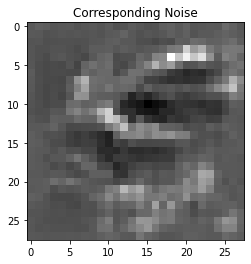

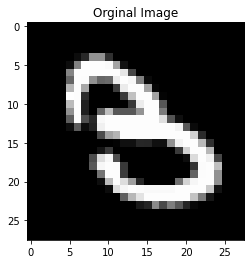

In [161]:
adv_gen_3(modelWithVis, 5, 3, image , mean = 1 , epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

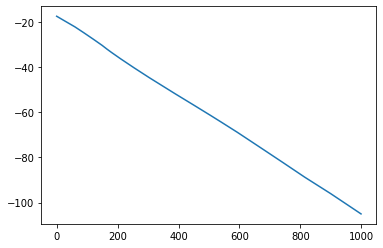

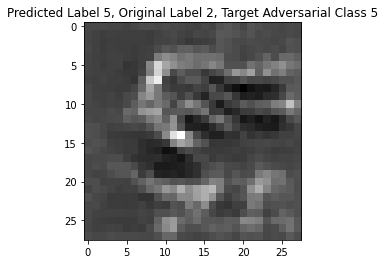

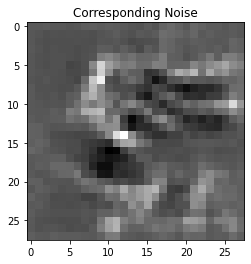

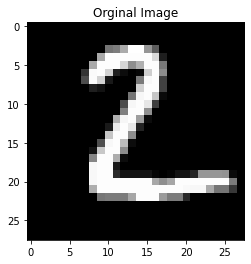

In [162]:
adv_gen_3(modelWithVis, 5, 2, image , mean = 4 , epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

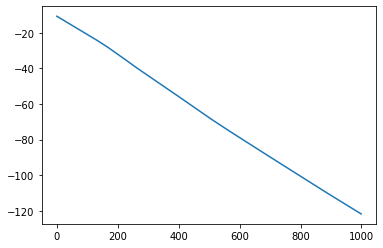

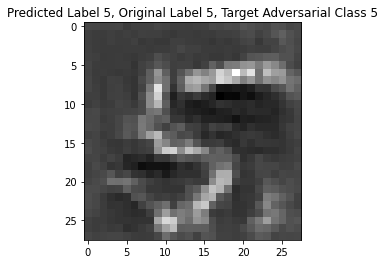

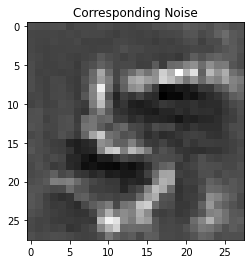

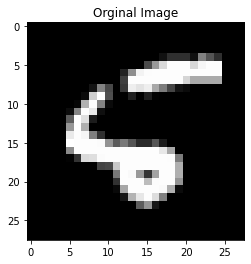

In [163]:
adv_gen_3(modelWithVis, 5, 5, image , mean = 1 , epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

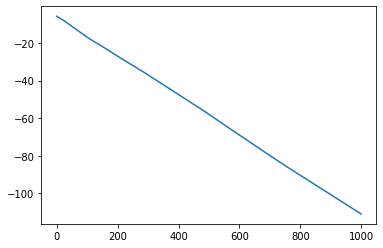

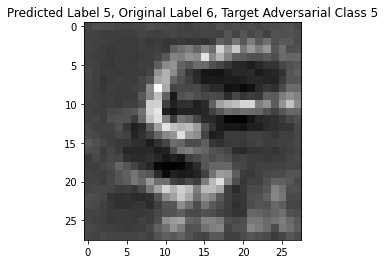

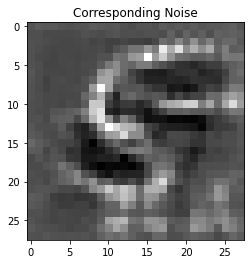

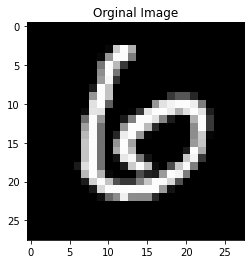

In [164]:
adv_gen_3(modelWithVis, 5, 6, image , mean = 1 , epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

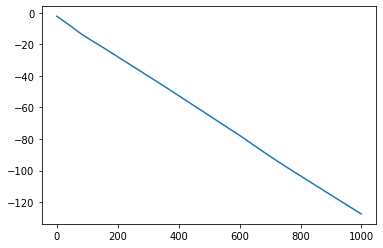

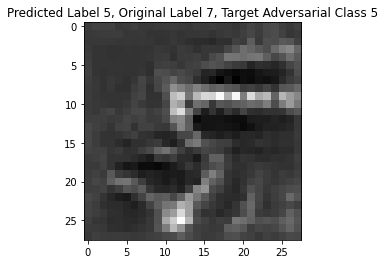

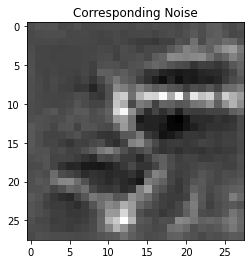

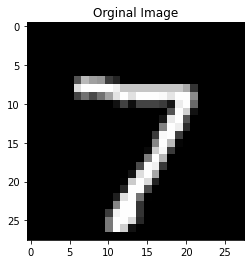

In [167]:
adv_gen_3(modelWithVis, 5, 7, image , mean = 1 , epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

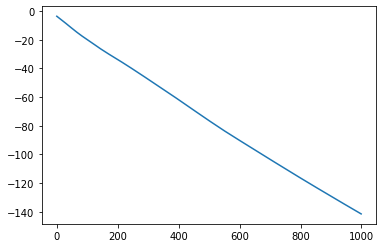

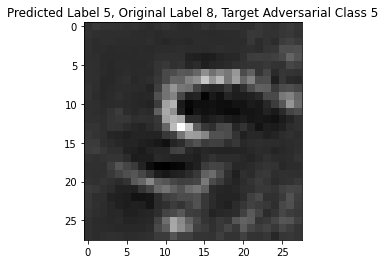

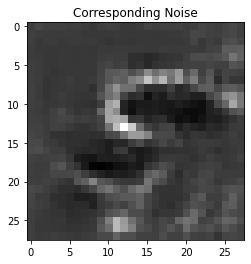

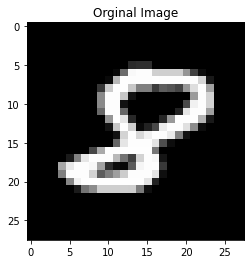

In [168]:
adv_gen_3(modelWithVis, 5, 8, image , mean = 1 , epochs=1000, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

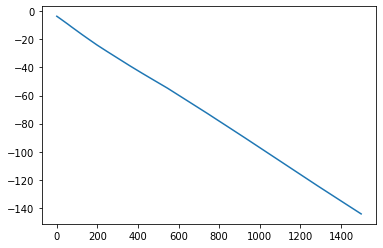

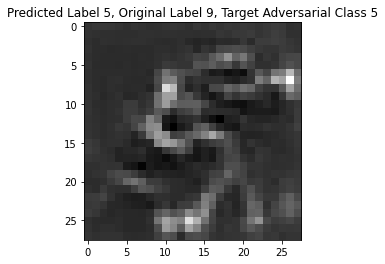

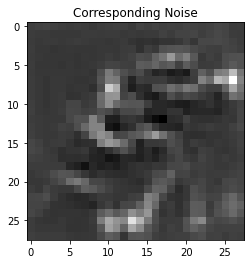

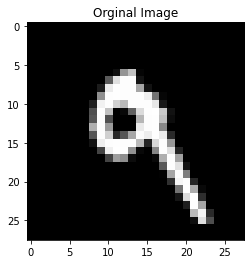

In [171]:
adv_gen_3(modelWithVis, 5, 9, image , mean = 0.5 , epochs=1500, plot_cost=True , device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))